# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
transcript_file = 'raw_compiled_transcripts.csv'

df = pd.read_csv(transcript_file)

all_participants = df['Participant_ID'].values

all_participants

array([300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352,
       353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
       366, 367, 368, 369, 370, 371, 372, 374, 375, 376, 377, 378, 379,
       380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392,
       393, 395, 396, 397, 399, 400, 401, 403, 404, 405, 406, 407, 408,
       409, 410, 411, 412, 413, 414, 415, 418, 419, 420, 421, 422, 423,
       424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436,
       437, 438, 439, 440, 441, 442, 443, 445, 446, 447, 448, 449, 450,
       452, 453, 454, 455, 456, 457, 459, 461, 462, 463, 464, 465, 466,
       467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479,
       481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 49

In [3]:
testfile = 'test_split_Depression_AVEC2017.csv'
test_participants = pd.read_csv(testfile)['participant_ID'].values

test_participants

array([300, 301, 306, 308, 309, 311, 314, 323, 329, 332, 334, 337, 349,
       354, 359, 361, 365, 378, 384, 387, 396, 399, 405, 407, 408, 410,
       411, 421, 424, 431, 432, 435, 438, 442, 450, 452, 453, 461, 462,
       465, 466, 467, 469, 470, 481])

## Distribution of test data
The test data is pre-determined by the research group. We will use the same test data so that we can benchmark our results with other researches.

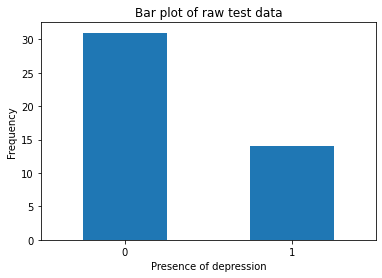

In [4]:
df_test = df[df.Participant_ID.isin(test_participants)]

df_test['PHQ_Binary'].value_counts().plot(kind='bar', rot=0)
plt.ylabel("Frequency")
plt.xlabel("Presence of depression")
plt.title("Bar plot of raw test data")
plt.show()

## Distribution of train data
This is the distribution of the data after filtering out the test participants. Clearly, our train dataset is small and imbalanced, which affects model training. Hence, we will use paraphrasing to upsample the number of transcripts for the participants in the trainset. The result will be a balanced train dataset for both nondepressed and depressed participants.

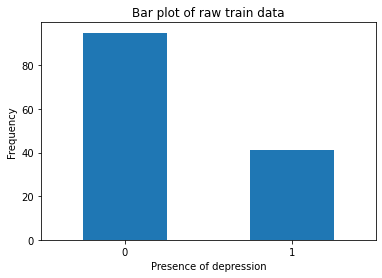

In [5]:
df_train = df[~df.Participant_ID.isin(test_participants)]

df_train['PHQ_Binary'].value_counts().plot(kind='bar', rot=0)
plt.ylabel("Frequency")
plt.xlabel("Presence of depression")
plt.title("Bar plot of raw train data")
plt.show()

# Upsampling for train dataset
We will upsample the number of non-depressed and depressed transcripts to 120 each.

In [6]:
TARGET_COUNT = 120

df_neg = df_train[df_train.PHQ_Binary == 0]
df_pos = df_train[df_train.PHQ_Binary == 1]

ori_neg_ids = df_neg.Participant_ID.values
ori_pos_ids = df_pos.Participant_ID.values

print(f"No of non-depressed: {len(ori_neg_ids)}. No of depressed: {len(ori_pos_ids)}")

No of non-depressed: 95. No of depressed: 41


In [7]:
def get_sampling_frame(ls, target_count):
    """
    Returns the sampling frame to be paraphrased, excluding the original sampling frame
    """
    random.seed(42)
    
    new_ls = []
    quotient = int(target_count / len(ls))
    remainder = target_count % len(ls)
    
    # if target_count >= size of given list
    if quotient > 0:
        # only fair to get every element
        new_ls = ls * (quotient - 1)
    
    # fill up the remaining spots
    new_ls += random.sample(ls, remainder)
    
    return new_ls

In [8]:
# negative sampling frame
aug_neg_ids = sorted(get_sampling_frame(list(ori_neg_ids), TARGET_COUNT))

print(aug_neg_ids)

[305, 307, 318, 324, 326, 331, 360, 364, 366, 368, 370, 379, 420, 423, 443, 454, 456, 468, 475, 476, 479, 482, 484, 487, 490]


In [9]:
# positive sampling frame
aug_pos_ids = sorted(get_sampling_frame(list(ori_pos_ids), TARGET_COUNT))

print(aug_pos_ids)

[319, 319, 320, 320, 321, 321, 325, 330, 330, 335, 335, 338, 338, 339, 339, 344, 344, 345, 346, 347, 347, 348, 348, 350, 350, 351, 351, 352, 352, 353, 353, 355, 355, 356, 356, 362, 362, 367, 367, 372, 372, 376, 376, 377, 377, 380, 380, 381, 381, 386, 386, 388, 388, 389, 389, 412, 412, 413, 413, 414, 414, 418, 418, 422, 422, 426, 426, 433, 433, 440, 440, 441, 441, 448, 448, 459, 459, 483, 483]


# Paraphrasing 

## 1. Google Translate
Translates to one of the foreign languages of random choice and then translate back again

In [10]:
!pip install paraphraser

from paraphraser import paraphrase

In [11]:
# Before paraphrasing
before_text = "i just want to paraphrase this sentence"

before_text

'i just want to paraphrase this sentence'

In [14]:
# After paraphrasing
after_text = paraphrase(before_text)[0]

after_text

'I just want to rewrite this sentence'

## Did not work

In [15]:
import time

def get_aug_df(ori_df, aug_ls_ids):
    aug_df = pd.DataFrame(columns=['Transcript', 'PHQ_Binary'])
    
    # there is gtoken issue intermittently so paraphrasing will run into errors
    while len(aug_ls_ids) != 0:

        participant_id = aug_ls_ids[0]
        
        try: 
            ori_text = ori_df[ori_df.Participant_ID == participant_id]['Transcript'].values[0]
            label = ori_df[ori_df.Participant_ID == participant_id]['PHQ_Binary'].values[0]
            para_text = paraphrase(ori_text)[0]
            if ori_text == para_text: # sometimes will return you the same text back
                continue
            else:
                aug_df = aug_df.append({'Transcript': para_text, 'PHQ_Binary': label}, ignore_index=True)
                aug_ls_ids.remove(participant_id)
            
        except Exception:
            time.sleep(2)
    
    return aug_df

# aug_df = get_aug_df(df_train, aug_pos_ids + aug_neg_ids)

# frames = [aug_df, df_train.drop(columns=['PHQ_Score'])]
# pd.concat(frames)

There are several issues with this paraphrasing library, which uses google translation API to another foreign language and then translate back.
1. gtoken will raise errors and blacklist your IP
2. Returned text might be the same or gibberish

Alternatives:
1. Use a trained [sentence generation model](https://github.com/vsuthichai/paraphraser) - worth trying only if a lot of augmentation is required.
2. Manually use online [paraphrasing tool](https://www.prepostseo.com/paraphrasing-tool) - more time efficient if dataset is small. We will be using this approach based on the ids generated above.

## 2. Web Paraphrasing Tool
Mainly relies on synonyms for paraphrasing.

In [16]:
augmented_transcript_file = 'augmented_compiled_transcripts.csv'

aug_df = pd.read_csv(augmented_transcript_file)

# before
aug_df[aug_df.Participant_ID == 338]['Transcript'].values[0]

"yes  i'm doing fine  i'm from los angeles california  wow wonderful weather um outdoor activities all the time too crowded pollution  the norm  i studied child communications um recently i just i would say yes preschool teacher  well i've always worked with children ever since i was eighteen years old so i figured doing something helping someone it doesn't pay well but you're investing in the future  wow some job that i could get paid to be outside all day get paid well to be outside all day  yes  i'm kinda quiet but i also like i probably would say borderline i like outside activities but i mainly kinda do um activities probably by myself so yeah i would say i'm an introvert slightly uh wow just um maybe a racist or disrespectful person i kinda shut down and and reevaluate how i am as a person how i'm coming off to other people i can't change anyone else's personality but i can work on my own   i'm pretty good  i usually don't argue with people i usually walk away i mean a argument d

In [17]:
# after
aug_df[aug_df.Participant_ID == 338]['Transcript'].values[1]

"sure i am doing excellent i am from la california wow remarkable climate um outside sports all of the time too crowded pollutants the norm i studied baby communications um lately i simply i'd say sure preschool trainer nicely i have continually labored with youngsters ever due to the fact i used to be eighteen years antique so i figured doing some thing supporting a person it would not pay nicely however you are making an investment withinside the destiny wow a few process that i should receives a commission to be outdoor all day receives a commission nicely to be outdoor all day sure i am kinda quiet however i additionally like i probable could say borderline i love outdoor sports however i specially kinda do um sports probable on my own so yeah i'd say i am an introvert barely uh wow simply um perhaps a racist or disrespectful individual i kinda close down and and reevaluate how i'm as someone how i am coming off to different human beings i can not extrade anybody else's character h

# View Augmented Train Distribution

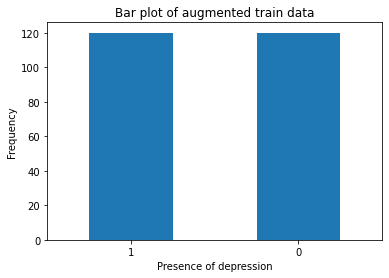

In [18]:
aug_df_train = aug_df[~aug_df.Participant_ID.isin(test_participants)]

aug_df_train['PHQ_Binary'].value_counts().plot(kind='bar', rot=0)
plt.ylabel("Frequency")
plt.xlabel("Presence of depression")
plt.title("Bar plot of augmented train data")
plt.show()